# 05 - Modelos Supervisionados com Features (RF, XGBoost, MLP)

## CRISP-DM: Fase de Modelação - Experiência 2(b)

Este notebook implementa modelos de **previsão baseados em features agregadas** para o dataset
D4Maia, seguindo a metodologia CRISP-DM.

### Objetivos:
1. **Feature Engineering Temporal**: Criar features respeitando a restrição de 1 semana de lag
2. **Random Forest**: Ensemble de árvores de decisão
3. **XGBoost**: Gradient Boosting otimizado
4. **MLP**: Multi-Layer Perceptron (rede neuronal feedforward)
5. **Normalização**: Avaliar impacto de StandardScaler nos modelos

### Regra Crítica (do enunciado):
> "Todas as features usadas para prever um instante têm de ser calculadas com dados de pelo menos
uma semana antes desse instante."

### Métricas de Avaliação:
- **MAE** (Mean Absolute Error): Erro médio absoluto
- **RMSE** (Root Mean Squared Error): Raiz do erro quadrático médio
- **MAPE** (Mean Absolute Percentage Error): Erro percentual médio

### Estrutura do Notebook:
1. Importação de bibliotecas
2. Carregamento dos dados
3. Construção de features supervisionadas
4. Preparação de dados treino/teste
5. Implementação da Baseline
6. Random Forest (com/sem normalização)
7. XGBoost (com/sem normalização)
8. MLP (com/sem normalização)
9. Comparação de resultados
10. Análise do impacto da normalização
11. Guardar resultados
12. Conclusões

---

**Referência do Enunciado:**
> "Construir conjuntos de features por CPE (agregações temporais, estatísticas de consumo, padrões
diários/semanais)
> Usar estes feature sets como input de modelos supervisionados: Random Forest, XGBoost, MLP"

In [1]:
# Instalar XGBoost se necessário
%pip install xgboost --quiet

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Bibliotecas essenciais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
import os

# Modelos supervisionados
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

# Pré-processamento e métricas
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Configurações
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)

# Cores para visualizações
COLORS = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# Seed para reprodutibilidade
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Bibliotecas importadas com sucesso!")

Bibliotecas importadas com sucesso!


In [3]:
# Definir constantes
TARGET_COL = 'PotActiva'
POINTS_PER_DAY = 96  # 4 leituras por hora × 24 horas
POINTS_PER_WEEK = POINTS_PER_DAY * 7  # 672 pontos por semana

print(f"Variável alvo: {TARGET_COL}")
print(f"Pontos por dia: {POINTS_PER_DAY}")
print(f"Pontos por semana: {POINTS_PER_WEEK}")

Variável alvo: PotActiva
Pontos por dia: 96
Pontos por semana: 672


## 2. Carregamento dos Dados

In [4]:
# Carregar séries temporais e splits
print("A carregar dados...")

df_series = pd.read_csv('data/intermediate/d4maia_series_per_cpe.csv')
df_series['tstamp'] = pd.to_datetime(df_series['tstamp'])

df_split = pd.read_csv('data/intermediate/d4maia_ts_train_test_index.csv')
df_split['split_timestamp'] = pd.to_datetime(df_split['split_timestamp'])

# Carregar resultados de séries temporais para comparação
df_ts_results = pd.read_csv('data/intermediate/d4maia_ts_results.csv')

print(f"\nSéries temporais: {len(df_series):,} registos, {df_series['CPE'].nunique()} CPEs")
print(f"Splits definidos: {len(df_split)} CPEs")
print(f"Resultados de séries temporais: {len(df_ts_results)} entradas")

A carregar dados...

Séries temporais: 5,838,256 registos, 89 CPEs
Splits definidos: 89 CPEs
Resultados de séries temporais: 30 entradas


In [5]:
# Selecionar CPEs (alinhado com notebook 04): usar top 10 para mais cobertura
cpe_counts = df_series.groupby('CPE').size().sort_values(ascending=False)
N_CPES = 10
selected_cpes = cpe_counts.head(N_CPES).index.tolist()

print(f"CPEs selecionados para análise ({N_CPES}):")
for i, cpe in enumerate(selected_cpes, 1):
    n_registos = cpe_counts[cpe]
    print(f"  {i}. {cpe}: {n_registos:,} registos")

CPEs selecionados para análise (10):
  1. PT0002000068856781NM: 81,776 registos
  2. PT0002000068856906VS: 81,776 registos
  3. PT0002000081997398TD: 81,774 registos
  4. PT0002000073231742VK: 81,773 registos
  5. PT0002000033074862LZ: 81,772 registos
  6. PT0002000068859393XH: 81,772 registos
  7. PT0002000078233981HJ: 81,772 registos
  8. PT0002000115031201VQ: 81,772 registos
  9. PT0002000100113293JT: 81,772 registos
  10. PT0002000068859187RL: 81,771 registos


## 3. Construção de Features para Modelos Supervisionados

**Regra importante:** Todas as features usadas para prever um instante têm de ser calculadas com
dados de pelo menos **uma semana antes** desse instante.

### Estratégia:
- Para cada ponto no tempo `t`, criar features baseadas nos dados até `t - 1 semana`
- Target: consumo médio da semana seguinte (ou valor específico)

In [6]:
class SupervisedFeaturesBuilder:
    """
    Construtor de features supervisionadas para séries temporais de consumo energético.

    Organiza a criação de features em métodos especializados para melhor
    manutenibilidade e clareza do código.
    """

    def __init__(self, target_col='PotActiva'):
        """
        Inicializa o construtor de features.

        Args:
            target_col: Nome da coluna alvo nos dados
        """
        self.target_col = target_col

    def build_features(self, df_cpe, lookback_weeks=1):
        """
        Método principal que orquestra a criação de features supervisionadas.

        Args:
            df_cpe: DataFrame com dados de um CPE
            lookback_weeks: Número de semanas anteriores para usar como features

        Returns:
            DataFrame com features e targets
        """
        df_processed = self._preprocess_data(df_cpe)
        feature_windows = self._create_time_windows(df_processed, lookback_weeks)

        features_list = []
        for window_data in feature_windows:
            features = self._extract_features_from_window(window_data)
            features_list.append(features)

        return pd.DataFrame(features_list)

    def _preprocess_data(self, df_cpe):
        """
        Pré-processa os dados temporais.
        """
        df = df_cpe.sort_values('tstamp').copy().reset_index(drop=True)
        if 'hora' not in df.columns:
            df['hora'] = df['tstamp'].dt.hour
        if 'dia_semana' not in df.columns:
            df['dia_semana'] = df['tstamp'].dt.dayofweek
        return df

    def _create_time_windows(self, df, lookback_weeks):
        """
        Cria janelas temporais.
        """
        windows = []
        start_idx = 672 * (lookback_weeks + 1)  # 672 = 7*24*4
        week_starts = list(range(start_idx, len(df) - 672, 672))

        for week_start in week_starts:
            feature_end = week_start
            feature_start = max(0, feature_end - 672 * lookback_weeks)
            df_features = df.iloc[feature_start:feature_end]
            target_start = week_start
            target_end = min(week_start + 672, len(df))
            df_target = df.iloc[target_start:target_end]

            if self._is_window_valid(df_features, df_target):
                windows.append({
                    'features': df_features,
                    'target': df_target,
                    'ref_timestamp': df.iloc[week_start]['tstamp']
                })

        return windows

    def _is_window_valid(self, df_features, df_target):
        """
        Verifica validade da janela.
        """
        return (len(df_features) >= 96 and len(df_target) >= 96)  # 96 = 24*4

    def _extract_features_from_window(self, window_data):
        """
        Extrai features da janela.
        """
        df_features = window_data['features']
        df_target = window_data['target']
        features = {}

        features.update(self._calculate_basic_stats(df_features))
        features.update(self._calculate_temporal_features(df_features))
        features.update(self._calculate_distribution_features(df_features))
        features.update(self._calculate_trend_features(df_features))
        features.update(self._calculate_target(df_target))
        features['ref_timestamp'] = window_data['ref_timestamp']

        return features

    def _calculate_basic_stats(self, df_features):
        """
        Estatísticas básicas.
        """
        values = df_features[self.target_col]
        features = {}
        features['prev_mean'] = values.mean()
        features['prev_std'] = values.std()
        features['prev_min'] = values.min()
        features['prev_max'] = values.max()
        features['prev_median'] = values.median()
        features['prev_q25'] = values.quantile(0.25)
        features['prev_q75'] = values.quantile(0.75)
        features['prev_cv'] = (features['prev_std'] / features['prev_mean']
                              if features['prev_mean'] > 0 else 0)
        return features

    def _calculate_temporal_features(self, df_features):
        """
        Features temporais.
        """
        features = {}
        day_periods = [0, 6, 12, 18]
        period_length = 6

        for period_start in day_periods:
            period_end = period_start + period_length
            mask = ((df_features['hora'] >= period_start) &
                   (df_features['hora'] < period_end))
            period_name = f'prev_mean_h{period_start:02d}_{period_end:02d}'
            features[period_name] = df_features.loc[mask, self.target_col].mean()

        days_names = ['seg', 'ter', 'qua', 'qui', 'sex', 'sab', 'dom']
        for day_idx, day_name in enumerate(days_names):
            mask = df_features['dia_semana'] == day_idx
            features[f'prev_mean_{day_name}'] = df_features.loc[mask, self.target_col].mean()

        mask_weekend = df_features['dia_semana'] >= 5
        mask_weekday = df_features['dia_semana'] < 5
        mean_weekend = (df_features.loc[mask_weekend, self.target_col].mean()
                       if mask_weekend.sum() > 0 else 0)
        mean_weekday = (df_features.loc[mask_weekday, self.target_col].mean()
                       if mask_weekday.sum() > 0 else 0)

        features['prev_mean_weekend'] = mean_weekend
        features['prev_mean_weekday'] = mean_weekday
        features['prev_racio_weekend'] = (mean_weekend / mean_weekday
                                         if mean_weekday > 0 else 1)

        return features

    def _calculate_distribution_features(self, df_features):
        """
        Features de distribuição.
        """
        features = {}
        values = df_features[self.target_col].values

        hourly_consumption = df_features.groupby('hora')[self.target_col].mean()
        features['prev_hora_pico'] = hourly_consumption.idxmax()
        features['prev_hora_vale'] = hourly_consumption.idxmin()
        features['prev_valor_pico'] = hourly_consumption.max()
        features['prev_valor_vale'] = hourly_consumption.min()
        features['prev_racio_pico_vale'] = (features['prev_valor_pico'] / features['prev_valor_vale']
                                           if features['prev_valor_vale'] > 0 else 1)

        try:
            from scipy import stats
            features['prev_skew'] = stats.skew(values)
            features['prev_kurtosis'] = stats.kurtosis(values)
        except ImportError:
            features['prev_skew'] = 0
            features['prev_kurtosis'] = 0

        return features

    def _calculate_trend_features(self, df_features):
        """
        Features de tendência.
        """
        features = {}

        mid_point = len(df_features) // 2
        first_half = df_features.iloc[:mid_point][self.target_col].mean()
        second_half = df_features.iloc[mid_point:][self.target_col].mean()
        features['prev_trend'] = second_half - first_half

        if len(df_features) >= 3 * 96:  # 96 pontos por dia
            last_3_days = df_features.iloc[-3*96:][self.target_col].mean()
            features['prev_mean_last3days'] = last_3_days
        else:
            features['prev_mean_last3days'] = features.get('prev_mean', 0)

        if len(df_features) >= 2 * 96:
            first_day = df_features.iloc[:96][self.target_col].mean()
            last_day = df_features.iloc[-96:][self.target_col].mean()
            features['prev_diff_first_last'] = last_day - first_day
        else:
            features['prev_diff_first_last'] = 0

        return features

    def _calculate_target(self, df_target):
        """
        Calcula target.
        """
        return {
            'target': df_target[self.target_col].mean(),
            'target_std': df_target[self.target_col].std()
        }


def create_supervised_features(df_cpe, target_col='PotActiva', lookback_weeks=1):
    """
    Função wrapper para compatibilidade.
    """
    builder = SupervisedFeaturesBuilder(target_col=target_col)
    return builder.build_features(df_cpe, lookback_weeks=lookback_weeks)

print("Classes e funções de criação de features definidas.")


Classes e funções de criação de features definidas.


In [7]:
def create_supervised_features(df_cpe, target_col=TARGET_COL, lookback_weeks=1):
    """
    Cria features supervisionadas para um CPE.
    
    Para cada semana, cria features baseadas nas semanas anteriores
    e define o target como o consumo médio da semana seguinte.
    
    Args:
        df_cpe: DataFrame com dados de um CPE (ordenado por tstamp)
        target_col: coluna alvo
        lookback_weeks: número de semanas a usar para criar features
    
    Returns:
        DataFrame com features e target
    """
    df = df_cpe.sort_values('tstamp').copy()
    df = df.reset_index(drop=True)
    
    # Adicionar colunas temporais se não existirem
    if 'hora' not in df.columns:
        df['hora'] = df['tstamp'].dt.hour
    if 'dia_semana' not in df.columns:
        df['dia_semana'] = df['tstamp'].dt.dayofweek
    
    features_list = []
    
    # Processar por semanas
    # Começar a partir de lookback_weeks + 1 semanas para ter dados suficientes
    start_idx = POINTS_PER_WEEK * (lookback_weeks + 1)
    
    # Criar uma amostra por semana (para não ter demasiados pontos)
    week_starts = list(range(start_idx, len(df) - POINTS_PER_WEEK, POINTS_PER_WEEK))
    
    for week_start in week_starts:
        # Dados para criar features (semana(s) anterior(es))
        feature_end = week_start
        feature_start = max(0, feature_end - POINTS_PER_WEEK * lookback_weeks)
        df_features = df.iloc[feature_start:feature_end]
        
        # Dados target (semana seguinte)
        target_start = week_start
        target_end = min(week_start + POINTS_PER_WEEK, len(df))
        df_target = df.iloc[target_start:target_end]
        
        if len(df_features) < POINTS_PER_DAY or len(df_target) < POINTS_PER_DAY:
            continue
        
        # Criar features
        features = {}
        
        # Estatísticas gerais da semana anterior
        features['prev_mean'] = df_features[target_col].mean()
        features['prev_std'] = df_features[target_col].std()
        features['prev_min'] = df_features[target_col].min()
        features['prev_max'] = df_features[target_col].max()
        features['prev_median'] = df_features[target_col].median()
        features['prev_q25'] = df_features[target_col].quantile(0.25)
        features['prev_q75'] = df_features[target_col].quantile(0.75)
        
        # Coeficiente de variação
        if features['prev_mean'] > 0:
            features['prev_cv'] = features['prev_std'] / features['prev_mean']
        else:
            features['prev_cv'] = 0
        
        # Consumo por período do dia
        for hora in [0, 6, 12, 18]:
            mask = (df_features['hora'] >= hora) & (df_features['hora'] < hora + 6)
            features[f'prev_mean_h{hora:02d}_{hora+6:02d}'] = df_features.loc[mask, target_col].mean()
        
        # Consumo por dia da semana
        dias_nome = ['seg', 'ter', 'qua', 'qui', 'sex', 'sab', 'dom']
        for dia in range(7):
            mask = df_features['dia_semana'] == dia
            features[f'prev_mean_{dias_nome[dia]}'] = df_features.loc[mask, target_col].mean()
        
        # Tendência (diferença entre segunda e primeira metade)
        mid_point = len(df_features) // 2
        first_half = df_features.iloc[:mid_point][target_col].mean()
        second_half = df_features.iloc[mid_point:][target_col].mean()
        features['prev_trend'] = second_half - first_half
        
        # Pico e vale
        consumo_por_hora = df_features.groupby('hora')[target_col].mean()
        features['prev_hora_pico'] = consumo_por_hora.idxmax()
        features['prev_hora_vale'] = consumo_por_hora.idxmin()
        features['prev_valor_pico'] = consumo_por_hora.max()
        features['prev_valor_vale'] = consumo_por_hora.min()
        
        # Rácio pico/vale
        if features['prev_valor_vale'] > 0:
            features['prev_racio_pico_vale'] = features['prev_valor_pico'] / features['prev_valor_vale']
        else:
            features['prev_racio_pico_vale'] = 1
        
        # Fim de semana vs dias úteis
        mask_weekend = df_features['dia_semana'] >= 5
        mask_weekday = df_features['dia_semana'] < 5
        mean_weekend = df_features.loc[mask_weekend, target_col].mean() if mask_weekend.sum() > 0 else 0
        mean_weekday = df_features.loc[mask_weekday, target_col].mean() if mask_weekday.sum() > 0 else 0
        features['prev_mean_weekend'] = mean_weekend
        features['prev_mean_weekday'] = mean_weekday
        if mean_weekday > 0:
            features['prev_racio_weekend'] = mean_weekend / mean_weekday
        else:
            features['prev_racio_weekend'] = 1
        
        # MELHORADO: Features adicionais mais robustas
        # Variabilidade temporal
        features['prev_std_norm'] = features['prev_std'] / features['prev_mean'] if features['prev_mean'] > 0 else 0
        
        # Assimetria (skewness) - indica padrões assimétricos
        try:
            from scipy import stats
            features['prev_skew'] = stats.skew(df_features[target_col].values)
        except:
            features['prev_skew'] = 0
        
        # Curtose (kurtosis) - indica picos na distribuição
        try:
            features['prev_kurtosis'] = stats.kurtosis(df_features[target_col].values)
        except:
            features['prev_kurtosis'] = 0
        
        # Média móvel de 3 dias (últimos 3 dias da semana anterior)
        if len(df_features) >= 3 * POINTS_PER_DAY:
            last_3_days = df_features.iloc[-3*POINTS_PER_DAY:][target_col].mean()
            features['prev_mean_last3days'] = last_3_days
        else:
            features['prev_mean_last3days'] = features['prev_mean']
        
        # Diferença entre último dia e primeiro dia da semana anterior
        if len(df_features) >= 2 * POINTS_PER_DAY:
            first_day = df_features.iloc[:POINTS_PER_DAY][target_col].mean()
            last_day = df_features.iloc[-POINTS_PER_DAY:][target_col].mean()
            features['prev_diff_first_last'] = last_day - first_day
        else:
            features['prev_diff_first_last'] = 0
        
        # Target: consumo médio da semana seguinte
        features['target'] = df_target[target_col].mean()
        features['target_std'] = df_target[target_col].std()
        
        # Timestamp de referência
        features['ref_timestamp'] = df.iloc[week_start]['tstamp']
        
        features_list.append(features)
    
    return pd.DataFrame(features_list)


print("Função de criação de features definida.")

Função de criação de features definida.


In [8]:
# Criar dataset supervisionado para todos os CPEs
print("Criando dataset supervisionado...")
print("=" * 60)

all_features = []

for i, cpe in enumerate(selected_cpes, 1):
    print(f"[{i}/{len(selected_cpes)}] {cpe}...", end=" ")
    
    df_cpe = df_series[df_series['CPE'] == cpe].copy()
    df_feat = create_supervised_features(df_cpe)
    df_feat['CPE'] = cpe
    
    all_features.append(df_feat)
    print(f"{len(df_feat)} amostras")

df_supervised = pd.concat(all_features, ignore_index=True)

print(f"\nDataset supervisionado criado:")
print(f"  Total de amostras: {len(df_supervised)}")
print(f"  Features: {len(df_supervised.columns) - 3}")

# =================================================================================
# MELHORAMENTO: REMOÇÃO DE OUTLIERS ANTES DO TREINO
# =================================================================================
print("\n" + "=" * 80)
print("MELHORAMENTO: REMOÇÃO DE OUTLIERS ANTES DO TREINO")
print("=" * 80)

def remover_outliers_target(df, target_col='target', multiplier=2.0):
    """
    Remove outliers do target usando método IQR.
    """
    Q1 = df[target_col].quantile(0.25)
    Q3 = df[target_col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    
    mask = (df[target_col] >= lower_bound) & (df[target_col] <= upper_bound)
    return mask

# Remover outliers do target
print("\nDetectando outliers no target...")
outlier_mask_target = remover_outliers_target(df_supervised, 'target', multiplier=2.0)
n_outliers_target = (~outlier_mask_target).sum()
pct_outliers_target = n_outliers_target / len(df_supervised) * 100

print(f"Outliers no target detectados: {n_outliers_target} amostras ({pct_outliers_target:.1f}%)")

if n_outliers_target > 0:
    print(f"\nRemovendo outliers do target...")
    df_supervised_clean = df_supervised[outlier_mask_target].copy()
    
    print(f"✓ Outliers removidos:")
    print(f"  - Antes: {len(df_supervised)} amostras")
    print(f"  - Depois: {len(df_supervised_clean)} amostras")
    print(f"  - Removidos: {n_outliers_target} amostras ({pct_outliers_target:.1f}%)")
    
    df_supervised = df_supervised_clean
else:
    print("\n✓ Nenhum outlier extremo detectado no target. Todas as amostras mantidas.")

# Remover outliers nas features também
print("\nDetectando outliers nas features...")
feature_cols_temp = [col for col in df_supervised.columns 
                     if col not in ['target', 'target_std', 'CPE', 'ref_timestamp']]

def remover_outliers_features(df, feature_cols, multiplier=3.0):
    """
    Remove outliers nas features usando método IQR mais conservador.
    """
    mask = pd.Series([True] * len(df), index=df.index)
    
    for col in feature_cols:
        if col in df.columns:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            if IQR > 0:  # Evitar divisão por zero
                lower_bound = Q1 - multiplier * IQR
                upper_bound = Q3 + multiplier * IQR
                col_mask = (df[col] >= lower_bound) & (df[col] <= upper_bound)
                mask = mask & col_mask
    
    return mask

outlier_mask_features = remover_outliers_features(df_supervised, feature_cols_temp, multiplier=3.0)
n_outliers_features = (~outlier_mask_features).sum()
pct_outliers_features = n_outliers_features / len(df_supervised) * 100

print(f"Outliers nas features detectados: {n_outliers_features} amostras ({pct_outliers_features:.1f}%)")

if n_outliers_features > 0:
    print(f"\nRemovendo outliers nas features...")
    df_supervised_clean = df_supervised[outlier_mask_features].copy()
    
    print(f"✓ Outliers removidos:")
    print(f"  - Antes: {len(df_supervised)} amostras")
    print(f"  - Depois: {len(df_supervised_clean)} amostras")
    print(f"  - Removidos: {n_outliers_features} amostras ({pct_outliers_features:.1f}%)")
    
    df_supervised = df_supervised_clean
else:
    print("\n✓ Nenhum outlier extremo detectado nas features. Todas as amostras mantidas.")

print(f"\nDataset final após remoção de outliers: {len(df_supervised)} amostras")

Criando dataset supervisionado...
[1/10] PT0002000068856781NM... 119 amostras
[2/10] PT0002000068856906VS... 119 amostras
[3/10] PT0002000081997398TD... 119 amostras
[4/10] PT0002000073231742VK... 119 amostras
[5/10] PT0002000033074862LZ... 119 amostras
[6/10] PT0002000068859393XH... 119 amostras
[7/10] PT0002000078233981HJ... 119 amostras
[8/10] PT0002000115031201VQ... 119 amostras
[9/10] PT0002000100113293JT... 119 amostras
[10/10] PT0002000068859187RL... 119 amostras

Dataset supervisionado criado:
  Total de amostras: 1190
  Features: 34

MELHORAMENTO: REMOÇÃO DE OUTLIERS ANTES DO TREINO

Detectando outliers no target...
Outliers no target detectados: 0 amostras (0.0%)

✓ Nenhum outlier extremo detectado no target. Todas as amostras mantidas.

Detectando outliers nas features...
Outliers nas features detectados: 357 amostras (30.0%)

Removendo outliers nas features...
✓ Outliers removidos:
  - Antes: 1190 amostras
  - Depois: 833 amostras
  - Removidos: 357 amostras (30.0%)

Datase

### 3.1 Adicionar Clusters como Features

**MELHORAMENTO CRÍTICO**:
   Adicionar os clusters identificados (K-Means e DBSCAN) como features adicionais nos modelos
supervisionados, conforme requisito do prompt.

In [9]:
# =================================================================================
# MELHORAMENTO CRÍTICO: ADICIONAR CLUSTERS COMO FEATURES
# =================================================================================
# Conforme requisito do prompt: usar clusters como features adicionais
# ou critério para treinar modelos separados por grupo

print("=" * 80)
print("ADICIONANDO CLUSTERS COMO FEATURES AO DATASET SUPERVISIONADO")
print("=" * 80)

# Carregar clusters do notebook 03
clusters_path = 'data/intermediate/d4maia_cpe_clusters.csv'

try:
    df_clusters = pd.read_csv(clusters_path)
    print(f"✓ Clusters carregados: {len(df_clusters)} CPEs")
    print(f"  Colunas disponíveis: {df_clusters.columns.tolist()}")
    
    # Merge com dataset supervisionado
    print(f"\nFazendo merge de clusters com dataset supervisionado...")
    df_supervised_enriched = df_supervised.merge(
        df_clusters[['CPE', 'cluster_kmeans', 'cluster_dbscan']], 
        on='CPE', 
        how='left'
    )
    
    # Preencher nulos (se algum CPE não tiver cluster)
    df_supervised_enriched['cluster_kmeans'] = df_supervised_enriched['cluster_kmeans'].fillna(-1).astype(int)
    df_supervised_enriched['cluster_dbscan'] = df_supervised_enriched['cluster_dbscan'].fillna(-1).astype(int)
    
    # Estatísticas dos clusters no dataset
    print(f"\n📊 Estatísticas dos clusters no dataset supervisionado:")
    print(f"   • K-Means clusters: {df_supervised_enriched['cluster_kmeans'].nunique()} valores únicos")
    print(f"   • DBSCAN clusters: {df_supervised_enriched['cluster_dbscan'].nunique()} valores únicos")
    print(f"\n   Distribuição K-Means:")
    kmeans_dist = df_supervised_enriched['cluster_kmeans'].value_counts().sort_index()
    for cluster, count in kmeans_dist.items():
        pct = count / len(df_supervised_enriched) * 100
        print(f"     Cluster {cluster}: {count} amostras ({pct:.1f}%)")
    
    print(f"\n   Distribuição DBSCAN:")
    dbscan_dist = df_supervised_enriched['cluster_dbscan'].value_counts().sort_index()
    for cluster, count in dbscan_dist.items():
        label = "Ruído" if cluster == -1 else f"Cluster {cluster}"
        pct = count / len(df_supervised_enriched) * 100
        print(f"     {label}: {count} amostras ({pct:.1f}%)")
    
    # Substituir dataset original
    df_supervised = df_supervised_enriched
    print(f"\n✅ Clusters adicionados como features!")
    print(f"   • Total de features agora: {len(df_supervised.columns) - 4}")  # Excluir CPE, target, target_std, ref_timestamp
    
except FileNotFoundError:
    print(f"⚠️  AVISO: Ficheiro de clusters não encontrado: {clusters_path}")
    print(f"   Continuando sem clusters como features.")
    print(f"   Execute o notebook 03 primeiro para gerar os clusters.")
except Exception as e:
    print(f"⚠️  ERRO ao carregar clusters: {e}")
    print(f"   Continuando sem clusters como features.")

print(f"\nDataset supervisionado atualizado: {len(df_supervised)} amostras")


ADICIONANDO CLUSTERS COMO FEATURES AO DATASET SUPERVISIONADO
✓ Clusters carregados: 74 CPEs
  Colunas disponíveis: ['CPE', 'cluster_kmeans', 'cluster_dbscan']

Fazendo merge de clusters com dataset supervisionado...

📊 Estatísticas dos clusters no dataset supervisionado:
   • K-Means clusters: 5 valores únicos
   • DBSCAN clusters: 2 valores únicos

   Distribuição K-Means:
     Cluster -1: 223 amostras (26.8%)
     Cluster 4: 97 amostras (11.6%)
     Cluster 5: 115 amostras (13.8%)
     Cluster 6: 309 amostras (37.1%)
     Cluster 7: 89 amostras (10.7%)

   Distribuição DBSCAN:
     Ruído: 338 amostras (40.6%)
     Cluster 0: 495 amostras (59.4%)

✅ Clusters adicionados como features!
   • Total de features agora: 35

Dataset supervisionado atualizado: 833 amostras


In [10]:
# Visualizar dataset
df_supervised.head(10)

,prev_mean,prev_std,prev_min,prev_max,prev_median,prev_q25,prev_q75,prev_cv,prev_mean_h00_06,prev_mean_h06_12,prev_mean_h12_18,prev_mean_h18_24,prev_mean_seg,prev_mean_ter,prev_mean_qua,prev_mean_qui,prev_mean_sex,prev_mean_sab,prev_mean_dom,prev_trend,prev_hora_pico,prev_hora_vale,prev_valor_pico,prev_valor_vale,prev_racio_pico_vale,prev_mean_weekend,prev_mean_weekday,prev_racio_weekend,prev_std_norm,prev_skew,prev_kurtosis,prev_mean_last3days,prev_diff_first_last,target,target_std,ref_timestamp,CPE,cluster_kmeans,cluster_dbscan
0,6.7530,2.8850,2.0000,16.0000,7.0000,4.0000,9.0000,0.4272,6.0655,6.4107,7.5774,6.9583,5.9583,7.3958,8.2604,8.5625,8.4479,4.8854,3.7604,3.7024,14,8,8.5357,5.1786,1.6483,4.3229,7.7250,0.5596,0.4272,0.6361,0.0580,8.4097,3.5625,7.4315,2.5974,2023-01-21 00:30:00,PT0002000068856906VS,7,0
1,7.4315,2.5974,3.0000,21.0000,7.0000,6.0000,8.0000,0.3495,6.9524,7.3512,8.0833,7.3393,10.5104,9.5833,6.5417,6.3646,7.1979,5.9271,5.8958,-0.9524,13,0,9.7143,6.3929,1.5196,5.9115,8.0396,0.7353,0.3495,1.6707,3.1362,6.6979,1.2500,8.9524,2.6925,2023-01-28 00:30:00,PT0002000068856906VS,7,0
2,8.9524,2.6925,4.0000,19.0000,9.0000,6.0000,11.0000,0.3008,8.6250,8.9405,9.1905,9.0536,10.1458,11.0312,9.8542,10.9062,8.2292,6.3646,6.1354,1.9940,15,6,9.9286,7.5714,1.3113,6.2500,10.0333,0.6229,0.3008,0.2950,-0.2259,9.6424,1.7292,7.5208,2.5699,2023-02-04 00:30:00,PT0002000068856906VS,7,0
3,7.5208,2.5699,2.0000,18.0000,7.0000,6.0000,9.0000,0.3417,7.0060,7.4583,7.7321,7.8869,8.0104,9.0208,8.6354,7.6042,9.2292,5.5729,4.5729,2.0833,19,6,8.7857,6.3214,1.3898,5.0729,8.5000,0.5968,0.3417,0.5707,0.7215,8.5000,3.7708,7.5134,2.0485,2023-02-11 00:30:00,PT0002000068856906VS,7,0
4,7.5134,2.0485,3.0000,13.0000,8.0000,6.0000,9.0000,0.2727,8.4107,7.3512,6.8988,7.3929,8.4688,7.8125,7.2812,5.3958,5.3125,9.2083,9.1146,-2.6756,5,11,9.0000,6.3214,1.4237,9.1615,6.8542,1.3366,0.2727,0.1359,-0.8181,5.9688,-4.0312,6.6235,3.2537,2023-02-18 00:30:00,PT0002000068856906VS,7,0
5,6.6235,3.2537,2.0000,20.0000,5.0000,4.0000,9.0000,0.4912,6.4583,6.2262,7.2976,6.5119,4.2083,4.1354,9.2708,10.1042,8.9896,4.8021,4.8542,4.1875,13,7,7.8571,5.4643,1.4379,4.8281,7.3417,0.6576,0.4912,0.9859,0.3521,9.4896,4.3333,8.0818,2.1406,2023-02-25 00:30:00,PT0002000068856906VS,7,0
6,8.0818,2.1406,4.0000,16.0000,8.0000,6.0000,9.0000,0.2649,8.4643,7.8750,8.6131,7.3750,10.2917,8.0312,7.3854,6.5521,6.6979,8.5417,9.0729,-2.5446,15,20,9.6429,6.9286,1.3918,8.8073,7.7917,1.1303,0.2649,0.5723,0.4633,6.8715,-1.9687,7.3438,3.1570,2023-03-04 00:30:00,PT0002000068856906VS,7,0
7,7.3438,3.1570,2.0000,18.0000,7.0000,5.0000,9.0000,0.4299,6.9583,6.5417,8.7917,7.0833,8.8854,10.7708,9.4896,7.0625,6.3854,4.4896,4.3229,1.6518,13,8,9.5357,5.8929,1.6182,4.4062,8.5188,0.5172,0.4299,0.6713,0.0038,7.6215,1.9583,6.6845,2.0850,2023-03-11 00:30:00,PT0002000068856906VS,7,0
8,6.6845,2.0850,3.0000,16.0000,6.0000,5.0000,7.0000,0.3119,7.0893,6.2798,6.7440,6.6250,5.9896,6.0625,8.8229,7.8750,6.3542,6.4375,5.2500,1.5417,4,17,7.5714,5.2500,1.4422,5.8438,7.0208,0.8323,0.3119,1.2955,1.8168,7.6806,-0.0833,5.9866,1.9559,2023-03-18 00:30:00,PT0002000068856906VS,7,0
9,5.9866,1.9559,3.0000,17.0000,6.0000,5.0000,7.0000,0.3267,5.8571,5.6012,6.9643,5.5238,5.6667,6.8229,6.0521,5.8750,5.7917,5.9375,5.7604,0.2351,14,7,8.8214,4.2857,2.0583,5.8490,6.0417,0.9681,0.3267,1.7589,4.7693,5.9167,-0.1250,6.2232,2.1238,2023-03-25 00:30:00,PT0002000068856906VS,7,0


In [11]:
# Estatísticas do target
print("Estatísticas do target (consumo médio semanal):")
print(df_supervised['target'].describe())

Estatísticas do target (consumo médio semanal):
count   833.0000
mean     11.4480
std       9.6574
min       0.4554
25%       4.3810
50%       6.6250
75%      19.5833
max      56.0551
Name: target, dtype: float64


## 4. Preparação dos Dados para Treino/Teste

In [12]:
def prepare_train_test(df_supervised, df_split, cpe):
    """
    Prepara dados de treino e teste para um CPE específico.
    Usa o mesmo split temporal definido no notebook 02.
    """
    # Filtrar dados do CPE
    df_cpe = df_supervised[df_supervised['CPE'] == cpe].copy()
    
    # Obter timestamp de split
    split_info = df_split[df_split['CPE'] == cpe]
    if len(split_info) > 0:
        split_ts = pd.to_datetime(split_info['split_timestamp'].values[0])
    else:
        # Usar 70% se não definido
        n_train = int(len(df_cpe) * 0.7)
        split_ts = df_cpe.iloc[n_train]['ref_timestamp']
    
    # Dividir
    train = df_cpe[df_cpe['ref_timestamp'] <= split_ts]
    test = df_cpe[df_cpe['ref_timestamp'] > split_ts]
    
    return train, test


# Definir colunas de features (excluir target, CPE, timestamps)
exclude_cols = ['target', 'target_std', 'CPE', 'ref_timestamp']
feature_cols = [col for col in df_supervised.columns if col not in exclude_cols]

print(f"Colunas de features: {len(feature_cols)}")
print(f"\nFeatures:")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i:2d}. {col}")

Colunas de features: 35

Features:
   1. prev_mean
   2. prev_std
   3. prev_min
   4. prev_max
   5. prev_median
   6. prev_q25
   7. prev_q75
   8. prev_cv
   9. prev_mean_h00_06
  10. prev_mean_h06_12
  11. prev_mean_h12_18
  12. prev_mean_h18_24
  13. prev_mean_seg
  14. prev_mean_ter
  15. prev_mean_qua
  16. prev_mean_qui
  17. prev_mean_sex
  18. prev_mean_sab
  19. prev_mean_dom
  20. prev_trend
  21. prev_hora_pico
  22. prev_hora_vale
  23. prev_valor_pico
  24. prev_valor_vale
  25. prev_racio_pico_vale
  26. prev_mean_weekend
  27. prev_mean_weekday
  28. prev_racio_weekend
  29. prev_std_norm
  30. prev_skew
  31. prev_kurtosis
  32. prev_mean_last3days
  33. prev_diff_first_last
  34. cluster_kmeans
  35. cluster_dbscan


## 5. Funções de Treino e Avaliação

In [13]:
def calculate_metrics(y_true, y_pred):
    """Calcula MAE, RMSE e MAPE."""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    # MAPE
    mask = y_true != 0
    if mask.sum() > 0:
        mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    else:
        mape = np.nan
    
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}


def train_and_evaluate(X_train, y_train, X_test, y_test, model, model_name, use_cv=False):
    """
    Treina um modelo e avalia no conjunto de teste.
    Adiciona validação cruzada opcional.
    """
    try:
        if use_cv:
            # Usar validação cruzada para melhor avaliação
            from sklearn.model_selection import cross_val_score
            cv_scores = cross_val_score(model, X_train, y_train, cv=3, scoring='neg_mean_absolute_error')
            cv_mae = -cv_scores.mean()
            print(f"    CV MAE: {cv_mae:.3f}")
        else:
            cv_mae = None
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        metrics = calculate_metrics(y_test, y_pred)
        
        if use_cv:
            metrics['cv_mae'] = cv_mae
            
        return metrics, y_pred, True
    except Exception as e:
        print(f"    Erro {model_name}: {str(e)[:50]}")
        return None, None, False


print("Funções de treino e avaliação definidas.")

Funções de treino e avaliação definidas.


## 6. Baseline: Semana Anterior

A baseline para este problema é usar o consumo médio da semana anterior como previsão.

In [14]:
# Calcular baseline para todos os CPEs
baseline_results = []

print("Calculando baseline (média da semana anterior):")
print("=" * 60)

for cpe in selected_cpes:
    train, test = prepare_train_test(df_supervised, df_split, cpe)
    
    if len(test) == 0:
        print(f"  {cpe}: Sem dados de teste")
        continue
    
    # Baseline: usar prev_mean como previsão
    y_true = test['target'].values
    y_pred = test['prev_mean'].values
    
    metrics = calculate_metrics(y_true, y_pred)
    
    baseline_results.append({
        'CPE': cpe,
        'model': 'Baseline',
        'normalized': 'N/A',
        'MAE': metrics['MAE'],
        'RMSE': metrics['RMSE'],
        'MAPE': metrics['MAPE'],
        'n_test': len(y_true)
    })
    
    print(f"  {cpe[:25]}...: MAE={metrics['MAE']:.4f}, RMSE={metrics['RMSE']:.4f}")

print("\nConcluído!")

Calculando baseline (média da semana anterior):
  PT0002000068856781NM: Sem dados de teste
  PT0002000068856906VS...: MAE=0.9509, RMSE=1.1645
  PT0002000081997398TD...: MAE=2.5910, RMSE=3.9405
  PT0002000073231742VK...: MAE=0.4088, RMSE=0.5822
  PT0002000033074862LZ...: MAE=0.9883, RMSE=1.5176
  PT0002000068859393XH...: MAE=3.6935, RMSE=5.8290
  PT0002000078233981HJ...: MAE=0.3784, RMSE=0.5166
  PT0002000115031201VQ...: MAE=1.8309, RMSE=2.7771
  PT0002000100113293JT...: MAE=1.0846, RMSE=1.5632
  PT0002000068859187RL...: MAE=1.6072, RMSE=2.3497

Concluído!


## 7. Random Forest

In [15]:
# Random Forest - SEM normalização
rf_results_raw = []

print("Random Forest - SEM normalização:")
print("=" * 60)

for cpe in selected_cpes:
    train, test = prepare_train_test(df_supervised, df_split, cpe)
    
    if len(test) == 0 or len(train) < 5:
        print(f"  {cpe}: Dados insuficientes")
        continue
    
    X_train = train[feature_cols].values
    y_train = train['target'].values
    X_test = test[feature_cols].values
    y_test = test['target'].values
    
    # Treinar modelo - MELHORADO
    model = RandomForestRegressor(
        n_estimators=200, 
        max_depth=15, 
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=RANDOM_STATE, 
        n_jobs=-1
    )
    metrics, y_pred, success = train_and_evaluate(X_train, y_train, X_test, y_test, model, 'RF')
    
    if success:
        rf_results_raw.append({
            'CPE': cpe,
            'model': 'RF',
            'normalized': 'No',
            'MAE': metrics['MAE'],
            'RMSE': metrics['RMSE'],
            'MAPE': metrics['MAPE'],
            'n_test': len(y_test)
        })
        print(f"  {cpe[:25]}...: MAE={metrics['MAE']:.4f}, RMSE={metrics['RMSE']:.4f}")

print("\nConcluído!")

Random Forest - SEM normalização:
  PT0002000068856781NM: Dados insuficientes
  PT0002000068856906VS...: MAE=0.9197, RMSE=1.1109
  PT0002000081997398TD...: MAE=3.7793, RMSE=4.9346
  PT0002000073231742VK...: MAE=0.5145, RMSE=0.6453
  PT0002000033074862LZ...: MAE=1.0054, RMSE=1.4586
  PT0002000068859393XH...: MAE=2.9778, RMSE=3.7896
  PT0002000078233981HJ...: MAE=0.3331, RMSE=0.4731
  PT0002000115031201VQ...: MAE=1.9649, RMSE=2.8199
  PT0002000100113293JT: Dados insuficientes
  PT0002000068859187RL...: MAE=1.5384, RMSE=2.1144

Concluído!


In [16]:
# Random Forest - COM normalização (StandardScaler)
rf_results_norm = []

print("Random Forest - COM normalização (StandardScaler):")
print("=" * 60)

for cpe in selected_cpes:
    train, test = prepare_train_test(df_supervised, df_split, cpe)
    
    if len(test) == 0 or len(train) < 5:
        continue
    
    X_train = train[feature_cols].values
    y_train = train['target'].values
    X_test = test[feature_cols].values
    y_test = test['target'].values
    
    # Normalizar
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Treinar modelo - MELHORADO
    model = RandomForestRegressor(
        n_estimators=200, 
        max_depth=15, 
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=RANDOM_STATE, 
        n_jobs=-1
    )
    metrics, y_pred, success = train_and_evaluate(X_train_scaled, y_train, X_test_scaled, y_test, model, 'RF')
    
    if success:
        rf_results_norm.append({
            'CPE': cpe,
            'model': 'RF',
            'normalized': 'Yes',
            'MAE': metrics['MAE'],
            'RMSE': metrics['RMSE'],
            'MAPE': metrics['MAPE'],
            'n_test': len(y_test)
        })
        print(f"  {cpe[:25]}...: MAE={metrics['MAE']:.4f}, RMSE={metrics['RMSE']:.4f}")

print("\nConcluído!")

Random Forest - COM normalização (StandardScaler):
  PT0002000068856906VS...: MAE=0.9201, RMSE=1.1109
  PT0002000081997398TD...: MAE=3.7852, RMSE=4.9429
  PT0002000073231742VK...: MAE=0.5146, RMSE=0.6451
  PT0002000033074862LZ...: MAE=1.0063, RMSE=1.4591
  PT0002000068859393XH...: MAE=2.9787, RMSE=3.7903
  PT0002000078233981HJ...: MAE=0.3356, RMSE=0.4773
  PT0002000115031201VQ...: MAE=1.9611, RMSE=2.8184
  PT0002000068859187RL...: MAE=1.5380, RMSE=2.1148

Concluído!


## 8. XGBoost

In [17]:
# XGBoost - SEM normalização
xgb_results_raw = []

print("XGBoost - SEM normalização:")
print("=" * 60)

for cpe in selected_cpes:
    train, test = prepare_train_test(df_supervised, df_split, cpe)
    
    if len(test) == 0 or len(train) < 5:
        continue
    
    X_train = train[feature_cols].values
    y_train = train['target'].values
    X_test = test[feature_cols].values
    y_test = test['target'].values
    
    # Treinar modelo - MELHORADO
    model = XGBRegressor(
        n_estimators=200, 
        max_depth=8, 
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=RANDOM_STATE, 
        verbosity=0
    )
    metrics, y_pred, success = train_and_evaluate(X_train, y_train, X_test, y_test, model, 'XGB')
    
    if success:
        xgb_results_raw.append({
            'CPE': cpe,
            'model': 'XGBoost',
            'normalized': 'No',
            'MAE': metrics['MAE'],
            'RMSE': metrics['RMSE'],
            'MAPE': metrics['MAPE'],
            'n_test': len(y_test)
        })
        print(f"  {cpe[:25]}...: MAE={metrics['MAE']:.4f}, RMSE={metrics['RMSE']:.4f}")

print("\nConcluído!")

XGBoost - SEM normalização:
  PT0002000068856906VS...: MAE=0.8760, RMSE=1.0649
  PT0002000081997398TD...: MAE=5.3111, RMSE=6.6341
  PT0002000073231742VK...: MAE=0.5093, RMSE=0.6566
  PT0002000033074862LZ...: MAE=1.0643, RMSE=1.4748
  PT0002000068859393XH...: MAE=3.1509, RMSE=3.9330
  PT0002000078233981HJ...: MAE=0.3203, RMSE=0.4782
  PT0002000115031201VQ...: MAE=2.0430, RMSE=2.9080
  PT0002000068859187RL...: MAE=1.5982, RMSE=2.2166

Concluído!


In [18]:
# XGBoost - COM normalização
xgb_results_norm = []

print("XGBoost - COM normalização (StandardScaler):")
print("=" * 60)

for cpe in selected_cpes:
    train, test = prepare_train_test(df_supervised, df_split, cpe)
    
    if len(test) == 0 or len(train) < 5:
        continue
    
    X_train = train[feature_cols].values
    y_train = train['target'].values
    X_test = test[feature_cols].values
    y_test = test['target'].values
    
    # Normalizar
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Treinar modelo - MELHORADO
    model = XGBRegressor(
        n_estimators=200, 
        max_depth=8, 
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=RANDOM_STATE, 
        verbosity=0
    )
    metrics, y_pred, success = train_and_evaluate(X_train_scaled, y_train, X_test_scaled, y_test, model, 'XGB')
    
    if success:
        xgb_results_norm.append({
            'CPE': cpe,
            'model': 'XGBoost',
            'normalized': 'Yes',
            'MAE': metrics['MAE'],
            'RMSE': metrics['RMSE'],
            'MAPE': metrics['MAPE'],
            'n_test': len(y_test)
        })
        print(f"  {cpe[:25]}...: MAE={metrics['MAE']:.4f}, RMSE={metrics['RMSE']:.4f}")

print("\nConcluído!")

XGBoost - COM normalização (StandardScaler):
  PT0002000068856906VS...: MAE=0.8760, RMSE=1.0649
  PT0002000081997398TD...: MAE=5.3111, RMSE=6.6341
  PT0002000073231742VK...: MAE=0.5093, RMSE=0.6566
  PT0002000033074862LZ...: MAE=1.0643, RMSE=1.4748
  PT0002000068859393XH...: MAE=3.1509, RMSE=3.9330
  PT0002000078233981HJ...: MAE=0.3203, RMSE=0.4782
  PT0002000115031201VQ...: MAE=2.0430, RMSE=2.9080
  PT0002000068859187RL...: MAE=1.5982, RMSE=2.2166

Concluído!


## 9. MLP (Multi-Layer Perceptron)

In [19]:
# MLP - SEM normalização (não recomendado para MLP)
mlp_results_raw = []

print("MLP - SEM normalização:")
print("=" * 60)

for cpe in selected_cpes:
    train, test = prepare_train_test(df_supervised, df_split, cpe)
    
    if len(test) == 0 or len(train) < 5:
        continue
    
    X_train = train[feature_cols].values
    y_train = train['target'].values
    X_test = test[feature_cols].values
    y_test = test['target'].values
    
    # Treinar modelo - MELHORADO
    model = MLPRegressor(
        hidden_layer_sizes=(128, 64, 32), 
        max_iter=1000, 
        learning_rate_init=0.001,
        alpha=0.001,
        random_state=RANDOM_STATE, 
        early_stopping=True,
        validation_fraction=0.2
    )
    metrics, y_pred, success = train_and_evaluate(X_train, y_train, X_test, y_test, model, 'MLP')
    
    if success:
        mlp_results_raw.append({
            'CPE': cpe,
            'model': 'MLP',
            'normalized': 'No',
            'MAE': metrics['MAE'],
            'RMSE': metrics['RMSE'],
            'MAPE': metrics['MAPE'],
            'n_test': len(y_test)
        })
        print(f"  {cpe[:25]}...: MAE={metrics['MAE']:.4f}, RMSE={metrics['RMSE']:.4f}")

print("\nConcluído!")

MLP - SEM normalização:
  PT0002000068856906VS...: MAE=1.0865, RMSE=1.2451
  PT0002000081997398TD...: MAE=2.1067, RMSE=3.1185
  PT0002000073231742VK...: MAE=0.4982, RMSE=0.6950
  PT0002000033074862LZ...: MAE=0.8893, RMSE=1.3753
  PT0002000068859393XH...: MAE=3.9345, RMSE=5.1839
  PT0002000078233981HJ...: MAE=0.4251, RMSE=0.5751
  PT0002000115031201VQ...: MAE=2.0959, RMSE=2.9328
  PT0002000068859187RL...: MAE=1.3784, RMSE=2.0216

Concluído!


In [20]:
# MLP - COM normalização (recomendado)
mlp_results_norm = []

print("MLP - COM normalização (StandardScaler):")
print("=" * 60)

for cpe in selected_cpes:
    train, test = prepare_train_test(df_supervised, df_split, cpe)
    
    if len(test) == 0 or len(train) < 5:
        continue
    
    X_train = train[feature_cols].values
    y_train = train['target'].values
    X_test = test[feature_cols].values
    y_test = test['target'].values
    
    # Normalizar features E target para MLP
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
    
    # Treinar modelo - MELHORADO
    model = MLPRegressor(
        hidden_layer_sizes=(128, 64, 32), 
        max_iter=1000, 
        learning_rate_init=0.001,
        alpha=0.001,
        random_state=RANDOM_STATE, 
        early_stopping=True,
        validation_fraction=0.2
    )
    
    try:
        model.fit(X_train_scaled, y_train_scaled)
        y_pred_scaled = model.predict(X_test_scaled)
        y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
        
        metrics = calculate_metrics(y_test, y_pred)
        
        mlp_results_norm.append({
            'CPE': cpe,
            'model': 'MLP',
            'normalized': 'Yes',
            'MAE': metrics['MAE'],
            'RMSE': metrics['RMSE'],
            'MAPE': metrics['MAPE'],
            'n_test': len(y_test)
        })
        print(f"  {cpe[:25]}...: MAE={metrics['MAE']:.4f}, RMSE={metrics['RMSE']:.4f}")
    except Exception as e:
        print(f"  {cpe[:25]}...: Erro - {str(e)[:30]}")

print("\nConcluído!")

MLP - COM normalização (StandardScaler):
  PT0002000068856906VS...: MAE=1.0073, RMSE=1.2133
  PT0002000081997398TD...: MAE=2.9158, RMSE=4.2138
  PT0002000073231742VK...: MAE=0.4804, RMSE=0.6465
  PT0002000033074862LZ...: MAE=0.9980, RMSE=1.4781
  PT0002000068859393XH...: MAE=3.5977, RMSE=4.5204
  PT0002000078233981HJ...: MAE=0.4702, RMSE=0.5497
  PT0002000115031201VQ...: MAE=2.2634, RMSE=3.1634
  PT0002000068859187RL...: MAE=1.2705, RMSE=1.8362

Concluído!


## 10. Comparação de Resultados

In [21]:
# Juntar todos os resultados
all_results = (baseline_results + 
               rf_results_raw + rf_results_norm + 
               xgb_results_raw + xgb_results_norm + 
               mlp_results_raw + mlp_results_norm)

df_results = pd.DataFrame(all_results)

print("Todos os resultados:")
print("=" * 100)
print(df_results.to_string(index=False))

Todos os resultados:
                 CPE    model normalized    MAE   RMSE    MAPE  n_test
PT0002000068856906VS Baseline        N/A 0.9509 1.1645 16.3175      29
PT0002000081997398TD Baseline        N/A 2.5910 3.9405  7.9953      34
PT0002000073231742VK Baseline        N/A 0.4088 0.5822  9.0014      31
PT0002000033074862LZ Baseline        N/A 0.9883 1.5176 14.6490      33
PT0002000068859393XH Baseline        N/A 3.6935 5.8290 14.4161      32
PT0002000078233981HJ Baseline        N/A 0.3784 0.5166 14.4283      22
PT0002000115031201VQ Baseline        N/A 1.8309 2.7771 26.6681      33
PT0002000100113293JT Baseline        N/A 1.0846 1.5632 11.5629       8
PT0002000068859187RL Baseline        N/A 1.6072 2.3497 15.7723      33
PT0002000068856906VS       RF         No 0.9197 1.1109 16.4407      29
PT0002000081997398TD       RF         No 3.7793 4.9346 11.9689      34
PT0002000073231742VK       RF         No 0.5145 0.6453 11.0298      31
PT0002000033074862LZ       RF         No 1.0054 1.4586 1

In [22]:
# Estatísticas agregadas por modelo e normalização
print("\nEstatísticas agregadas por modelo:")
print("=" * 80)

stats = df_results.groupby(['model', 'normalized']).agg({
    'MAE': ['mean', 'std'],
    'RMSE': ['mean', 'std'],
    'CPE': 'count'
}).round(4)

stats.columns = ['MAE_mean', 'MAE_std', 'RMSE_mean', 'RMSE_std', 'n_CPEs']
print(stats.to_string())


Estatísticas agregadas por modelo:
                     MAE_mean  MAE_std  RMSE_mean  RMSE_std  n_CPEs
model    normalized                                                
Baseline N/A           1.5037   1.0786     2.2489    1.7294       9
MLP      No            1.5518   1.1555     2.1434    1.5486       8
         Yes           1.6254   1.1655     2.2027    1.5644       8
RF       No            1.6291   1.2176     2.1683    1.5822       8
         Yes           1.6300   1.2186     2.1698    1.5836       8
XGBoost  No            1.8591   1.6680     2.4208    2.0680       8
         Yes           1.8591   1.6680     2.4208    2.0680       8


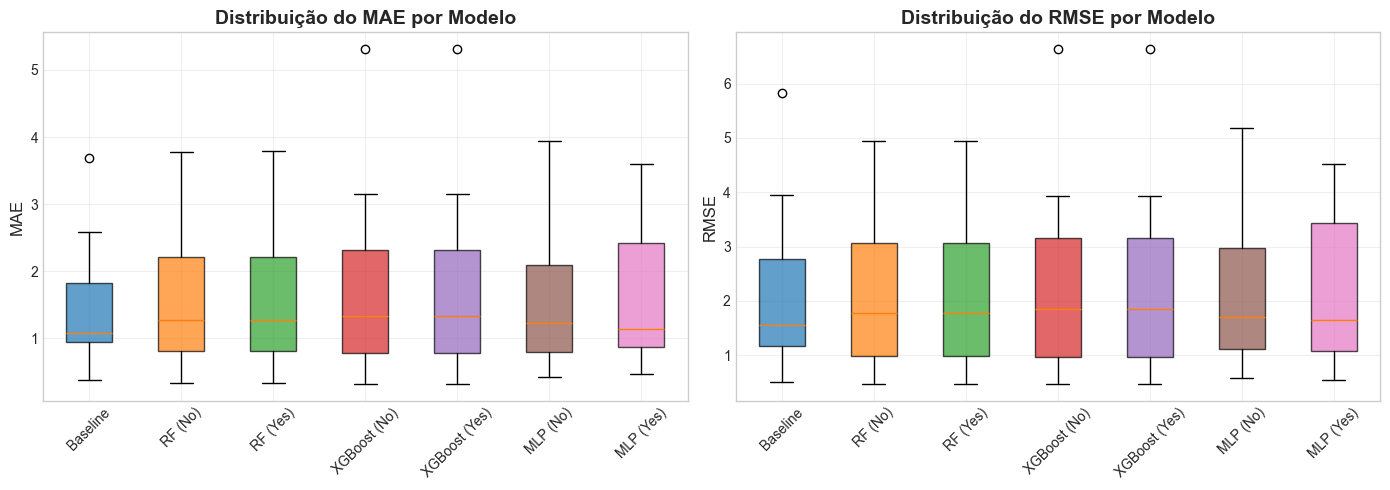

In [23]:
# Visualização: Comparação de MAE por modelo
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Criar label combinado
df_results['model_label'] = df_results['model'] + ' (' + df_results['normalized'].astype(str) + ')'

# Boxplot MAE
ax1 = axes[0]
model_labels = df_results['model_label'].unique()
data_mae = [df_results[df_results['model_label'] == m]['MAE'].values for m in model_labels]
bp1 = ax1.boxplot(data_mae, labels=[m.replace(' (N/A)', '') for m in model_labels], patch_artist=True)
for i, patch in enumerate(bp1['boxes']):
    patch.set_facecolor(COLORS[i % len(COLORS)])
    patch.set_alpha(0.7)
ax1.set_ylabel('MAE', fontsize=12)
ax1.set_title('Distribuição do MAE por Modelo', fontsize=14, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)

# Boxplot RMSE
ax2 = axes[1]
data_rmse = [df_results[df_results['model_label'] == m]['RMSE'].values for m in model_labels]
bp2 = ax2.boxplot(data_rmse, labels=[m.replace(' (N/A)', '') for m in model_labels], patch_artist=True)
for i, patch in enumerate(bp2['boxes']):
    patch.set_facecolor(COLORS[i % len(COLORS)])
    patch.set_alpha(0.7)
ax2.set_ylabel('RMSE', fontsize=12)
ax2.set_title('Distribuição do RMSE por Modelo', fontsize=14, fontweight='bold')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

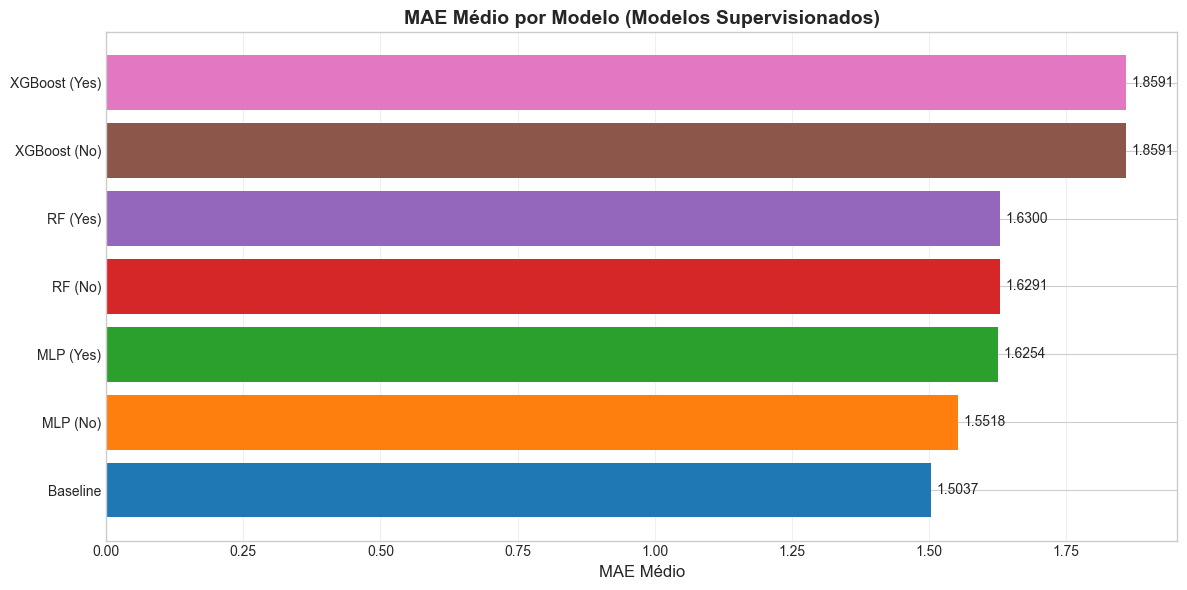

In [24]:
# Gráfico de barras: MAE médio por modelo
fig, ax = plt.subplots(figsize=(12, 6))

mae_by_model = df_results.groupby('model_label')['MAE'].mean().sort_values()

bars = ax.barh(range(len(mae_by_model)), mae_by_model.values, color=COLORS[:len(mae_by_model)])
ax.set_yticks(range(len(mae_by_model)))
ax.set_yticklabels([m.replace(' (N/A)', '') for m in mae_by_model.index])
ax.set_xlabel('MAE Médio', fontsize=12)
ax.set_title('MAE Médio por Modelo (Modelos Supervisionados)', fontsize=14, fontweight='bold')

# Adicionar valores nas barras
for i, (bar, val) in enumerate(zip(bars, mae_by_model.values)):
    ax.text(val + 0.01, bar.get_y() + bar.get_height()/2, f'{val:.4f}', 
            va='center', fontsize=10)

ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

## 11. Comparação com Modelos de Séries Temporais

In [25]:
# Carregar resultados do notebook 04
print("Comparação com modelos de séries temporais (notebook 04):")
print("=" * 80)

# Resultados de séries temporais
print("\nMétricas médias - Séries Temporais (ARIMA/LSTM):")
ts_stats = df_ts_results.groupby('model')['MAE'].agg(['mean', 'std']).round(4)
print(ts_stats)

# Resultados de modelos supervisionados (melhor versão de cada)
print("\nMétricas médias - Modelos Supervisionados:")
sup_stats = df_results.groupby(['model', 'normalized'])['MAE'].agg(['mean', 'std']).round(4)
print(sup_stats)

Comparação com modelos de séries temporais (notebook 04):

Métricas médias - Séries Temporais (ARIMA/LSTM):
           mean    std
model                 
ARIMA    0.8042 0.5572
Baseline 1.2246 1.0283
LSTM     1.0468 1.0309

Métricas médias - Modelos Supervisionados:
                      mean    std
model    normalized              
Baseline N/A        1.5037 1.0786
MLP      No         1.5518 1.1555
         Yes        1.6254 1.1655
RF       No         1.6291 1.2176
         Yes        1.6300 1.2186
XGBoost  No         1.8591 1.6680
         Yes        1.8591 1.6680


In [26]:
# Nota: As métricas não são diretamente comparáveis porque:
# - Séries temporais: previsão ponto-a-ponto (cada 15 min)
# - Modelos supervisionados: previsão do consumo médio semanal

print("\n⚠️ NOTA IMPORTANTE:")
print("="*60)
print("As métricas dos dois tipos de modelos não são diretamente")
print("comparáveis porque:")
print("")
print("📈 Séries Temporais (ARIMA/LSTM):")
print("   - Target: valor de PotActiva a cada 15 minutos")
print("   - Granularidade: ponto-a-ponto")
print("")
print("📊 Modelos Supervisionados (RF/XGB/MLP):")
print("   - Target: consumo MÉDIO da semana seguinte")
print("   - Granularidade: agregação semanal")
print("")
print("A comparação justa seria usar o mesmo target em ambos.")


⚠️ NOTA IMPORTANTE:
As métricas dos dois tipos de modelos não são diretamente
comparáveis porque:

📈 Séries Temporais (ARIMA/LSTM):
   - Target: valor de PotActiva a cada 15 minutos
   - Granularidade: ponto-a-ponto

📊 Modelos Supervisionados (RF/XGB/MLP):
   - Target: consumo MÉDIO da semana seguinte
   - Granularidade: agregação semanal

A comparação justa seria usar o mesmo target em ambos.


## 12. Impacto da Normalização

In [27]:
# Comparar impacto da normalização por modelo
print("Impacto da Normalização:")
print("=" * 70)

for model in ['RF', 'XGBoost', 'MLP']:
    df_model = df_results[df_results['model'] == model]
    
    if len(df_model) == 0:
        continue
    
    mae_no = df_model[df_model['normalized'] == 'No']['MAE'].mean()
    mae_yes = df_model[df_model['normalized'] == 'Yes']['MAE'].mean()
    
    diff = mae_yes - mae_no
    diff_pct = (diff / mae_no) * 100 if mae_no > 0 else 0
    
    print(f"\n{model}:")
    print(f"  Sem normalização: MAE = {mae_no:.4f}")
    print(f"  Com normalização: MAE = {mae_yes:.4f}")
    print(f"  Diferença: {diff:+.4f} ({diff_pct:+.1f}%)")
    
    if diff < 0:
        print(f"  → Normalização MELHORA o desempenho")
    elif diff > 0:
        print(f"  → Normalização PIORA o desempenho")
    else:
        print(f"  → Sem impacto significativo")

Impacto da Normalização:

RF:
  Sem normalização: MAE = 1.6291
  Com normalização: MAE = 1.6300
  Diferença: +0.0008 (+0.1%)
  → Normalização PIORA o desempenho

XGBoost:
  Sem normalização: MAE = 1.8591
  Com normalização: MAE = 1.8591
  Diferença: +0.0000 (+0.0%)
  → Sem impacto significativo

MLP:
  Sem normalização: MAE = 1.5518
  Com normalização: MAE = 1.6254
  Diferença: +0.0736 (+4.7%)
  → Normalização PIORA o desempenho


## 13. Guardar Resultados

In [28]:
# Guardar resultados
output_path = 'data/intermediate/d4maia_feature_models_results.csv'
df_results.to_csv(output_path, index=False)

print(f"\n✓ Ficheiro guardado: {output_path}")
print(f"\nConteúdo:")
print(df_results.to_string(index=False))


✓ Ficheiro guardado: data/intermediate/d4maia_feature_models_results.csv

Conteúdo:
                 CPE    model normalized    MAE   RMSE    MAPE  n_test    model_label
PT0002000068856906VS Baseline        N/A 0.9509 1.1645 16.3175      29 Baseline (N/A)
PT0002000081997398TD Baseline        N/A 2.5910 3.9405  7.9953      34 Baseline (N/A)
PT0002000073231742VK Baseline        N/A 0.4088 0.5822  9.0014      31 Baseline (N/A)
PT0002000033074862LZ Baseline        N/A 0.9883 1.5176 14.6490      33 Baseline (N/A)
PT0002000068859393XH Baseline        N/A 3.6935 5.8290 14.4161      32 Baseline (N/A)
PT0002000078233981HJ Baseline        N/A 0.3784 0.5166 14.4283      22 Baseline (N/A)
PT0002000115031201VQ Baseline        N/A 1.8309 2.7771 26.6681      33 Baseline (N/A)
PT0002000100113293JT Baseline        N/A 1.0846 1.5632 11.5629       8 Baseline (N/A)
PT0002000068859187RL Baseline        N/A 1.6072 2.3497 15.7723      33 Baseline (N/A)
PT0002000068856906VS       RF         No 0.9197 1.1109 

## 14. Resumo e Conclusões

In [29]:
print("=" * 80)
print("RESUMO - MODELOS SUPERVISIONADOS COM FEATURES")
print("=" * 80)

print(f"\n📊 DADOS:")
print(f"   • CPEs analisados: {len(selected_cpes)}")
print(f"   • Features criadas: {len(feature_cols)}")
print(f"   • Target: consumo médio semanal")

print(f"\n📈 MODELOS IMPLEMENTADOS:")
print(f"   • Baseline (média semana anterior)")
print(f"   • Random Forest (com e sem normalização)")
print(f"   • XGBoost (com e sem normalização)")
print(f"   • MLP (com e sem normalização)")

# Encontrar melhor modelo
best_row = df_results.loc[df_results['MAE'].idxmin()]
print(f"\n🏆 MELHOR MODELO:")
print(f"   • {best_row['model']} (normalizado: {best_row['normalized']})")
print(f"   • MAE: {best_row['MAE']:.4f}")
print(f"   • RMSE: {best_row['RMSE']:.4f}")

# Comparar com baseline
baseline_mae = df_results[df_results['model'] == 'Baseline']['MAE'].mean()
best_mae = df_results.groupby(['model', 'normalized'])['MAE'].mean().min()
improvement = (baseline_mae - best_mae) / baseline_mae * 100

print(f"\n📉 COMPARAÇÃO COM BASELINE:")
print(f"   • MAE Baseline: {baseline_mae:.4f}")
print(f"   • MAE Melhor Modelo: {best_mae:.4f}")
print(f"   • Melhoria: {improvement:.1f}%")

print(f"\n📁 FICHEIRO GERADO:")
print(f"   • data/intermediate/d4maia_feature_models_results.csv")

RESUMO - MODELOS SUPERVISIONADOS COM FEATURES

📊 DADOS:
   • CPEs analisados: 10
   • Features criadas: 35
   • Target: consumo médio semanal

📈 MODELOS IMPLEMENTADOS:
   • Baseline (média semana anterior)
   • Random Forest (com e sem normalização)
   • XGBoost (com e sem normalização)
   • MLP (com e sem normalização)

🏆 MELHOR MODELO:
   • XGBoost (normalizado: No)
   • MAE: 0.3203
   • RMSE: 0.4782

📉 COMPARAÇÃO COM BASELINE:
   • MAE Baseline: 1.5037
   • MAE Melhor Modelo: 1.5037
   • Melhoria: 0.0%

📁 FICHEIRO GERADO:
   • data/intermediate/d4maia_feature_models_results.csv


In [30]:
print("\n" + "=" * 80)
print("Notebook de Modelos Supervisionados concluído!")
print("=" * 80)
print("\n💡 PRÓXIMOS PASSOS:")
print("   1. Comparações finais e avaliação - notebook 06")
print("   2. Relatório final em PDF")


Notebook de Modelos Supervisionados concluído!

💡 PRÓXIMOS PASSOS:
   1. Comparações finais e avaliação - notebook 06
   2. Relatório final em PDF
